# Python script to plot data from 01EMMA_CYL

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from __future__ import print_function
import ipywidgets as widget

## Choose a netyCDF file to read 

In [2]:
file_name = 'cc_etat013.nc'
url_base = 'http://servdap.legi.grenoble-inp.fr:80/opendap/coriolis/01EMMA_CYL/cc/'
url = url_base + file_name
rootgrp = Dataset(url)

## plotting function

In [11]:
def g(variable, vector, setcolorbar, varmax, varmin):
    fig_xsize = 15
    fig_ysize = 10
    font_size = 25
    markersize = 10
    fig = plt.figure(num=0, figsize=(fig_xsize, fig_ysize), dpi=60,
                    facecolor='w', edgecolor='w')
    plt.rcParams.update({'font.size': font_size})
    plt.rcParams['lines.markersize'] = 10
    xaxis_name = 'i'
    yaxis_name = 'j'
    xlin = np.linspace(0, 49, 50)
    x, y = np.meshgrid(xlin, xlin)
    contourcolor = plt.cm.coolwarm
    if variable == 'norm':
        norm = np.sqrt(rootgrp.variables['u'][0, 0, :, :]**2 +
                       rootgrp.variables['v'][0, 0, :, :]**2)
        if setcolorbar:
            levels = np.linspace(varmin, varmax, 100)
            mycontour = plt.contourf(norm, levels, cmap=contourcolor)
        else:
            mycontour = plt.contourf(norm, 100, cmap=contourcolor)
        cbar = plt.colorbar(mycontour)
        cbar.ax.set_ylabel('Velocity (m/s)')
    else:
        varplot = rootgrp.variables[variable][0, 0, :, :]
        if setcolorbar:
            levels = np.linspace(varmin, varmax, 100)
            mycontour = plt.contourf(varplot, levels, cmap=contourcolor)
        else:
            mycontour = plt.contourf(varplot, 100, cmap=contourcolor)
        cbar = plt.colorbar(mycontour)
        cbar.ax.set_ylabel(rootgrp.variables[variable].name +
                           " (" + rootgrp.variables[variable].units + ")")
    if vector:
        plt.quiver(x, y, rootgrp.variables['u'][0, 0, :, :],
                   rootgrp.variables['v'][0, 0, :, :])
    plt.gca().set_aspect('equal')
    plt.xlabel(xaxis_name)
    plt.ylabel(yaxis_name)
    plt.show()

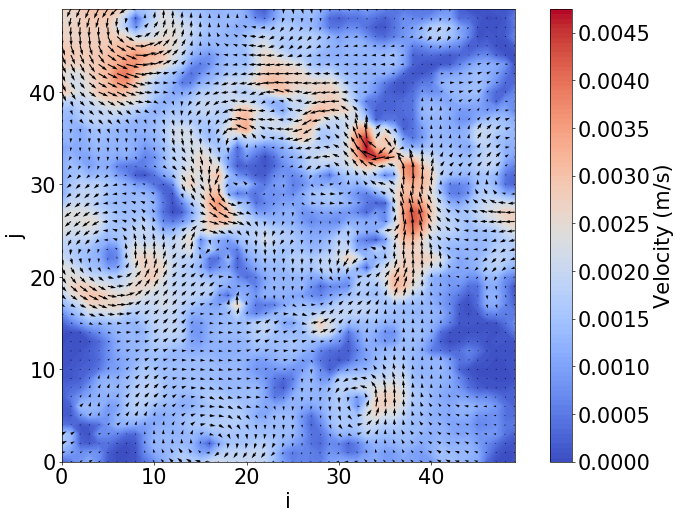

In [13]:
widget.interact(g,
                variable=widget.ToggleButtons(options=['u', 'v', 'norm'],
                                               description='Variable:',
                                               disabled=False,
                                               button_style='', # 'success', 'info', 'warning', 'danger' or ''
                                              ),
                vector=widget.Checkbox(value=False,
                                       description='Display vectors',
                                       disabled=False
                                      ),
                setcolorbar=False,
                varmin=widget.FloatText(value=-0.006,
                                        step=0.0001,
                                        description='value min:',
                                        disabled=False
                                       ),
                varmax=widget.FloatText(value=0.006,
                                        step=0.0001,
                                        description='value max:',
                                        disabled=False
                                       ),
               );